<a href="https://colab.research.google.com/github/elnazabbasifar/IMDB_BINARY_GNN_Classification/blob/main/IMDB_BINARY_GNN_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author**: Elnaz Abbasifar   
**Supervisor**: Dr. Gajamannage  
**Date**: June 7, 2025   

**Objective**: This dataset consists of graphs representing collaboration networks for movies.
Nodes are actors, and edges represent co-occurrence in a movie.
The task is to classify the movie genre (represented by each graph).

**Why IMDB-BINARY Dataset?** IMDB-BINARY is an **unattributed graph dataset**. Nodes (actors) have **no inherent features**, which means the GNN must learn representations solely from the graph structure (connectivity). This tests the model's ability to extract structural patterns.

**A common trick for unattributed graphs is to:**

- **Use a constant feature**: Every node gets a feature vector of all 1s (or some other constant value).
- **or use an identity matrix as features**: Each node i gets a one-hot encoded vector where the i-th element is 1 and others are 0. This essentially uses the node's unique identity as its feature. This is often the default behavior if num_node_features is 0 and we pass x=None to GCNConv.

**Dataset**: IMDB-BINARY from TUDataset (1000 graphs, 2 classes)  
**Model**: GCN with 3 convolution layers, global mean pooling, and a linear classification head  
**Implementation**: Based on PyTorch Geometric documentation  
**Result**: Achieved ~65–75% accuracy on the test set after 100 epochs

### 1. Install and Import Libraries:

In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.2 MB/s eta 0:00:00


In [37]:
import torch
import torch_geometric
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import degree
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import random # Needed for random.shuffle

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
#ensure that the PyTorch and the PyG are the same version
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


We will now create a function that will help us visualize a graph data.

In [48]:
def visualize_graph(G, colors):
  plt.figure(figsize=(7,7))
  plt.xticks([])
  plt.yticks([])
  nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                    node_color=colors, cmap="Set2")
  plt.show()

### 1.1. Configuration

In [49]:
# Set random seeds for reproducibility to ensure consistent results
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Define the device to use (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print(f"PyTorch Version: {torch.__version__}")
print(f"PyTorch Geometric Version: {torch_geometric.__version__}")

Using device: cpu
PyTorch Version: 2.6.0+cu124
PyTorch Geometric Version: 2.6.1


### 2. Load and Prepare Graph Data:

The IMDB-BINARY dataset, by default, is "unattributed," meaning its nodes (actors) do not come with inherent numerical features.
However, Graph Neural Networks (GNNs) typically require an input feature matrix (x) for their nodes.
To address this, we explicitly create node features for each graph.

In [50]:
dataset = TUDataset(root='./data/IMDB-BINARY', name='IMDB-BINARY')

# Assigning degree features to nodes
data_list_with_features = []
for i in range(len(dataset)):
  # Get the current Data object from the dataset
  current_graph = dataset[i]
  # Calculate node degree and assign it as a 1D feature vector to graph.x
  current_graph.x = degree(current_graph.edge_index[0], current_graph.num_nodes).unsqueeze(1)
  # Add the modified Data object to our new list
  data_list_with_features.append(current_graph)

print(f'Dataset: {dataset}:')
print('======================')
print('Number of graphs:', len(dataset))
print('Number of features:', dataset.num_features)
print('Number of classes:', dataset.num_classes)

data = dataset[0]  # Get the first graph object.
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is directed: {data.is_directed()}')

Dataset: IMDB-BINARY(1000):
Number of graphs: 1000
Number of features: 0
Number of classes: 2
Data(edge_index=[2, 146], y=[1], num_nodes=20)
Number of nodes: 20
Number of edges: 146
Has isolated nodes: False
Has self-loops: False
Is directed: False


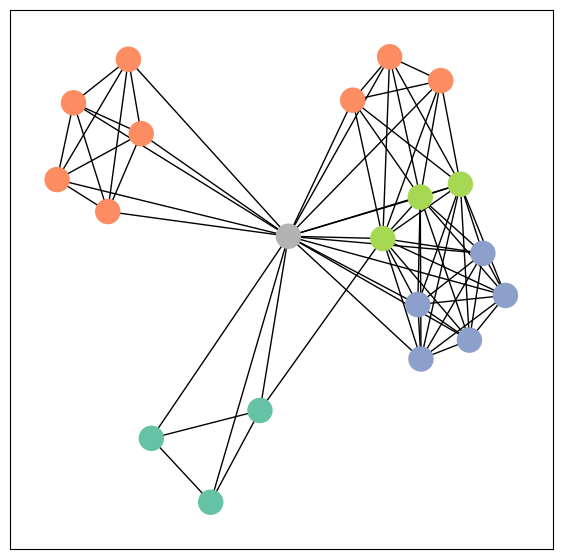

In [51]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)

# Calculate node degrees and use them for coloring
degrees = [degree for node, degree in G.degree()]

visualize_graph(G, colors=degrees)

In [52]:
labels = torch.cat([data.y for data in dataset], dim=0)
print("Class distribution in the whole dataset:", torch.bincount(labels)) # Shows class distribution

Class distribution in the whole dataset: tensor([500, 500])


### 2.1. Data Splitting

In [53]:
# Shuffle the dataset to ensure random distribution for splits
random.shuffle(data_list_with_features)

# Split the dataset into training (80%), validation (10%), and test (10%) sets.
train_dataset = data_list_with_features[:int(len(data_list_with_features)*0.8)]
val_dataset = data_list_with_features[int(len(dataset)*0.8):int(len(data_list_with_features)*0.9)]
test_dataset = data_list_with_features[int(len(data_list_with_features)*0.9):]

print(f'Number of graphs in training set: {len(train_dataset)}')
print(f'Number of graphs in validation set: {len(val_dataset)}')
print(f'Number of graphs in test set: {len(test_dataset)}')

Number of graphs in training set: 800
Number of graphs in validation set: 100
Number of graphs in test set: 100


In [54]:
# Checking for missing features in the modified data list (after assignment)
for i, graph in enumerate(data_list_with_features):
  if graph.x is None or graph.x.numel() == 0:
    print(f"Graph {i} has no features!")

### 2.2. DataLoaders

In [55]:
# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # Using large batch size because these graphs are generally small.
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### 3. Define the GNN Model:

In [56]:
# Define a 3-layer GCN model
class GCNClassifier(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, num_classes):
    super().__init__()

    # GCNConv layers for message passing between nodes.
    # num_node_features: input dimension for the first layer (will be 1 for unattributed graphs).
    # hidden_channels: dimension of node embeddings after each GCN layer.
    self.conv1 = GCNConv(in_channels, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, hidden_channels)
    self.conv3 = GCNConv(hidden_channels, hidden_channels)

    # Dropout layer for regularization to prevent overfitting.
    self.dropout = torch.nn.Dropout(0.2)

    # Final linear layer for graph classification.
    # It takes the graph-level embedding (output of global_mean_pool) and outputs logits for each class.
    self.lin = torch.nn.Linear(hidden_channels, num_classes)

    # Debug print to confirm model's input channel size
    print(f"Model initialized with conv1 input channels: {in_channels}")

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch

    # --------Handle cases where x (node features) might be None or empty------------
    # This block ensures GCNConv always receives a valid tensor input.
    # If 'data.x' is None or has no elements, it creates a tensor of ones as fallback features.
    # 'self.conv1.in_channels' ensures the tensor has the correct feature dimension (e.g., 1 for degree).
    if x is None or (x.dim() == 2 and x.size(1) == 0):
      print("Warning: Node features (x) are None or empty. Using default ones as features.")
      # Fallback: Create a tensor of ones with appropriate shape and device.
      x = torch.ones((data.num_nodes, self.conv1.in_channels), dtype=torch.float, device=edge_index.device)

    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.dropout(x)

    x = self.conv2(x, edge_index)
    x = F.relu(x)
    x = self.dropout(x)

    x = self.conv3(x, edge_index)
    x = F.relu(x)
    x = self.dropout(x)

    x = global_mean_pool(x, batch)

    # For binary classification with CrossEntropyLoss, we output raw logits.
    # CrossEntropyLoss internally applies softmax/log_softmax.
    return self.lin(x)

### 3.1. Create the Model Instance:

In [57]:
# Initialize the model
model = GCNClassifier(in_channels=1, hidden_channels=64, num_classes=2).to(device)

Model initialized with conv1 input channels: 1


### 3.2. Define Optimizer and Loss Function:

In [58]:
# Define Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.005) # Optimizer used for updating model weights

# Define Loss Function: CrossEntropyLoss is standard for multi-class classification (including binary).
criterion = torch.nn.CrossEntropyLoss()

print("GNN Model Architecture:")
print(model)

GNN Model Architecture:
GCNClassifier(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (dropout): Dropout(p=0.2, inplace=False)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


### 4. Train the Model:

In [59]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device) # Move data (graph batch) to the specified device

        optimizer.zero_grad() # Clear gradients from the previous training step
        out = model(data)     # Perform a forward pass to get model predictions

        loss = criterion(out, data.y) # Calculate the loss between predictions and true labels

        loss.backward()       # Perform backpropagation to compute gradients
        optimizer.step()
        total_loss += loss.item() * data.num_graphs # Accumulate loss for the epoch

    return total_loss / len(loader.dataset) # Return average loss per graph for the epoch

### 5. Evaluate the Model:

In [60]:
def evaluate_model(model, loader):
  model.eval()
  correct = 0
  total = 0
  y_true_all = [] # Store all true labels
  y_pred_all = [] # Store all predicted labels

  with torch.no_grad(): # Disable gradient calculation for evaluation (saves memory and speeds up)
    for data in loader:
      data = data.to(device)
      out = model(data)

      pred = out.argmax(dim=1) # Get the predicted class (index of the highest probability/logit)

      correct += (pred == data.y).sum().item() # Count correct predictions
      total += data.num_graphs # Count total graphs in batch

      y_true_all.extend(data.y.cpu().tolist()) # Store true labels (move to CPU for sklearn)
      y_pred_all.extend(pred.cpu().tolist()) # Store predicted labels (move to CPU for sklearn)

    accuracy = correct / total # Calculate overall accuracy

    return accuracy, y_true_all, y_pred_all # Return accuracy and lists of labels


### 6. Training Loop

In [61]:
epochs = 200 # Number of training epochs
best_val_acc = 0.0
best_model = None

train_losses = []
val_accuracies = []

for epoch in range(1, epochs + 1):
  # Train the model for one epoch on the training data
  train_loss = train_one_epoch(model, train_loader)
  val_acc, _, _ = evaluate_model(model, val_loader) # Unpack the tuple and only use the accuracy

  if val_acc > best_val_acc:
    best_val_acc = val_acc
    best_model = model.state_dict()

  # Store results for plotting
  train_losses.append(train_loss)
  val_accuracies.append(val_acc)

  # Print progress every 10 epochs or on the first epoch
  if epoch % 10 == 0 or epoch == 1:
      print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_acc:.4f}')

Epoch: 001, Train Loss: 0.7060, Val Accuracy: 0.3600
Epoch: 010, Train Loss: 0.6890, Val Accuracy: 0.6300
Epoch: 020, Train Loss: 0.6285, Val Accuracy: 0.6900
Epoch: 030, Train Loss: 0.5886, Val Accuracy: 0.7100
Epoch: 040, Train Loss: 0.5735, Val Accuracy: 0.7100
Epoch: 050, Train Loss: 0.5679, Val Accuracy: 0.7200
Epoch: 060, Train Loss: 0.5569, Val Accuracy: 0.7100
Epoch: 070, Train Loss: 0.5581, Val Accuracy: 0.7100
Epoch: 080, Train Loss: 0.5481, Val Accuracy: 0.7200
Epoch: 090, Train Loss: 0.5534, Val Accuracy: 0.7200
Epoch: 100, Train Loss: 0.5605, Val Accuracy: 0.7200
Epoch: 110, Train Loss: 0.5461, Val Accuracy: 0.7300
Epoch: 120, Train Loss: 0.5491, Val Accuracy: 0.6900
Epoch: 130, Train Loss: 0.5578, Val Accuracy: 0.7100
Epoch: 140, Train Loss: 0.5496, Val Accuracy: 0.7200
Epoch: 150, Train Loss: 0.5467, Val Accuracy: 0.7200
Epoch: 160, Train Loss: 0.5462, Val Accuracy: 0.7200
Epoch: 170, Train Loss: 0.5431, Val Accuracy: 0.7200
Epoch: 180, Train Loss: 0.5419, Val Accuracy: 

In [62]:
# Evaluate the model on the test set
# Load the best model and test it
model.load_state_dict(best_model)
test_acc, y_true_test, y_pred_test = evaluate_model(model, test_loader)
print(f'Final Accuracy on Test Set: {test_acc:.4f}')

Final Accuracy on Test Set: 0.6500


In [63]:
# Generate a detailed classification report on test set
print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.62      0.69      0.65        48
           1       0.68      0.62      0.65        52

    accuracy                           0.65       100
   macro avg       0.65      0.65      0.65       100
weighted avg       0.65      0.65      0.65       100



### 7. Visualization

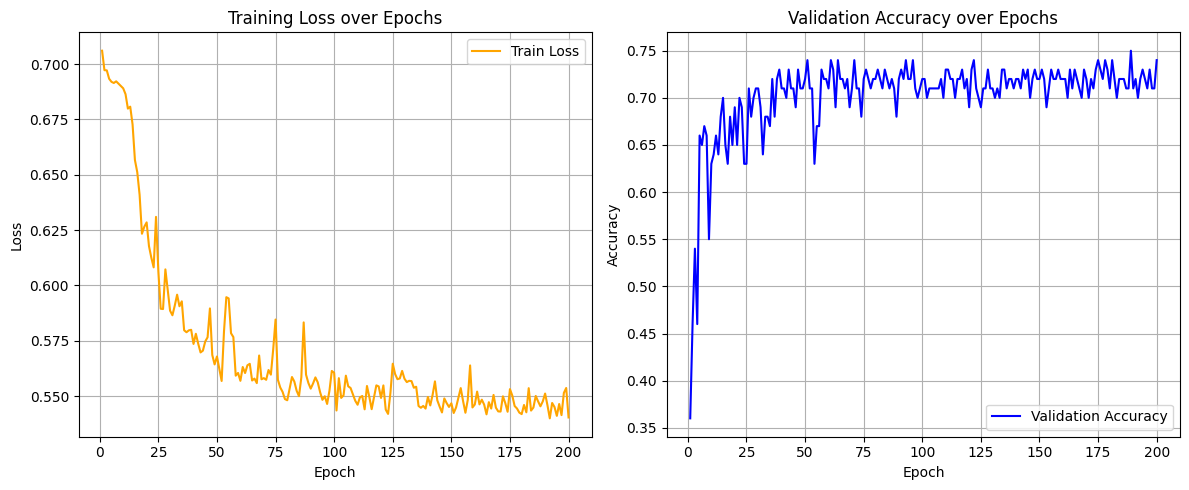

In [64]:
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()